For this analysis, we once again, will look at the Minnesota Data to look at the prices of acres per acre. This time there will be other variables that we will introduce that we did not use last time. Around 2007 there was a national drop in the price of land and we want to see if Minnesota was affected as well. Last time we used year as a continuous variable, this time we will utilize the variable as a factor. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan as ncvTest
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from scipy.stats import t
import pingouin as pg
import scipy.stats

MinnLand = pd.read_csv("http://users.stat.umn.edu/~sandy/alr4ed/data/MinnLand.csv")

print(MinnLand.head())

   Unnamed: 0  acrePrice     region  improvements  year  acres  tillable  \
0           1        766  Northwest           0.0  2002     82      94.0   
1           2        733  Northwest           0.0  2003     30      63.0   
2           3        850  Northwest           4.0  2002    150      47.0   
3           4        975  Northwest           0.0  2003    160      86.0   
4           5        886  Northwest          62.0  2002     90       NaN   

        financing  crpPct  productivity  
0  title_transfer       0           NaN  
1  title_transfer       0           NaN  
2  title_transfer       0           NaN  
3  title_transfer       0           NaN  
4  title_transfer       0           NaN  


In [2]:
print(MinnLand.describe(include="all"))

          Unnamed: 0     acrePrice   region  improvements          year  \
count   18700.000000  18700.000000    18700  18650.000000  18700.000000   
unique           NaN           NaN        6           NaN           NaN   
top              NaN           NaN  Central           NaN           NaN   
freq             NaN           NaN     4198           NaN           NaN   
mean     9350.500000   2787.333529      NaN      4.492922   2006.437273   
std      5398.369353   1914.040040      NaN     12.935014      2.507632   
min         1.000000    108.000000      NaN      0.000000   2002.000000   
25%      4675.750000   1425.000000      NaN      0.000000   2004.000000   
50%      9350.500000   2442.000000      NaN      0.000000   2006.000000   
75%     14025.250000   3702.000000      NaN      0.000000   2008.000000   
max     18700.000000  15000.000000      NaN    100.000000   2011.000000   

               acres      tillable       financing        crpPct  productivity  
count   18700.0000

Once again, we see the range of acrePrice and it seems to go over many orders which more than likely calls for a log transformation, which we will go ahead and do. The only predictor we are worried about at this moment is year. 

In [3]:
MinnLand["yearF"] = MinnLand["year"].astype("category")
MinnLand["acrePrice_log"] = np.log(MinnLand["acrePrice"])

acrePrice_log = MinnLand["acrePrice_log"]

yearF = MinnLand["yearF"] 

minnfit = smf.ols("acrePrice_log~C(year)", data=MinnLand).fit()
#yearF_c = sm.add_constant(yearF) 

#minnfit = sm.OLS(acrePrice_log, yearF_c).fit()

print(minnfit.summary())


                            OLS Regression Results                            
Dep. Variable:          acrePrice_log   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     308.5
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:22:26   Log-Likelihood:                -19249.
No. Observations:               18700   AIC:                         3.852e+04
Df Residuals:                   18690   BIC:                         3.860e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.2717      0.028    2

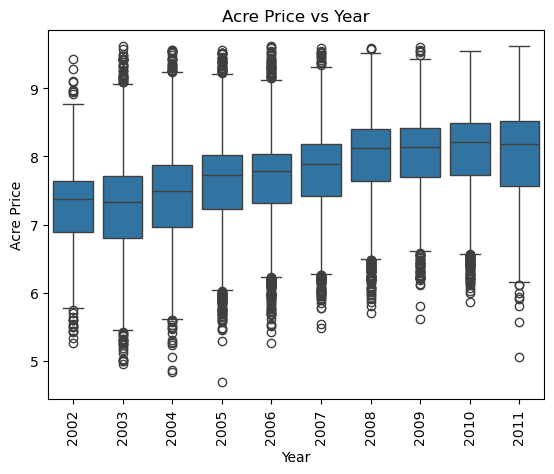

In [4]:
sns.boxplot(x=yearF,y=acrePrice_log)
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Acre Price")
plt.title("Acre Price vs Year")
plt.show()

Looking at both the summary and the boxplot, it seems as if the prices of acres seem to rise yearly, even in 2007. The summary table uses the year 2002 and every year, other than 2003, sees a rise even in 2007 with an increase of .477 dollars from 2003. All of these levels show significance from the baseline. We will use an anova later to further confirm it. We will do some more diagnostics. 

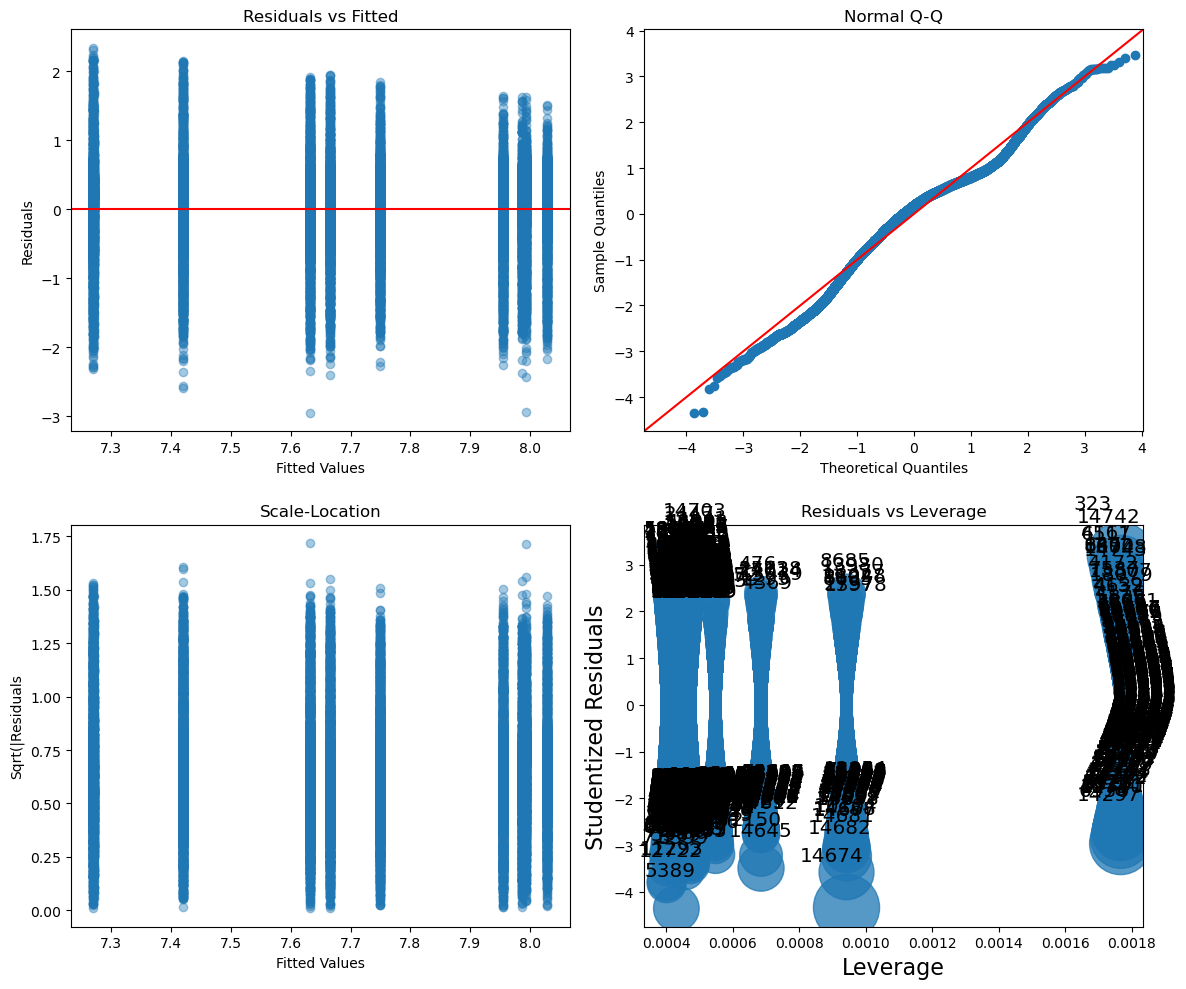

In [5]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(minnfit.fittedvalues, minnfit.resid, alpha=0.4)
axes[0,0].axhline(0, color='red')
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(minnfit.get_influence().resid_studentized_internal, line="45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(minnfit.fittedvalues, np.sqrt(np.abs(minnfit.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(minnfit, criterion="cooks", ax=axes[1,1])
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

In [6]:
minncvtest = ncvTest(minnfit.resid, minnfit.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, minncvtest):
    print(f"{stat}:{score}")

BP statistic:159.38871638622547
BP p-value:9.949062995210991e-30
f-value:17.85255239424586
f p-value:7.369193009362857e-30


 Both the charts and the ncv test show evidence of a non constant variance. Although we are using categorical data, we can see about using weights and how that may fix the variance issues. 

In [7]:
var = MinnLand.groupby("yearF", observed=True)["acrePrice"].var()

Wts = np.repeat(0.0, len(MinnLand["acrePrice_log"]))
#Wts = []
#Wts = 1/MinnLand["yearF"].map(var)
for i in range(0, len(MinnLand["acrePrice_log"])):
    Wts[i] = 1.0/(var[MinnLand["yearF"][i]])


    
minnfitwts = smf.wls("acrePrice_log~C(year)", data=MinnLand, weights=Wts).fit()
print(minnfitwts.summary())

                            WLS Regression Results                            
Dep. Variable:          acrePrice_log   R-squared:                       0.138
Model:                            WLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     332.5
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:25:21   Log-Likelihood:                -19298.
No. Observations:               18700   AIC:                         3.862e+04
Df Residuals:                   18690   BIC:                         3.869e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.2717      0.020    3

In [8]:
minncvtest2 = ncvTest(minnfitwts.resid, minnfitwts.model.exog)

labels = ["BP statistics", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, minncvtest2):
    print(f"{stat}:{score}")

BP statistics:159.38871638627117
BP p-value:9.94906299499346e-30
f-value:17.852552394250953
f p-value:7.369193009215408e-30


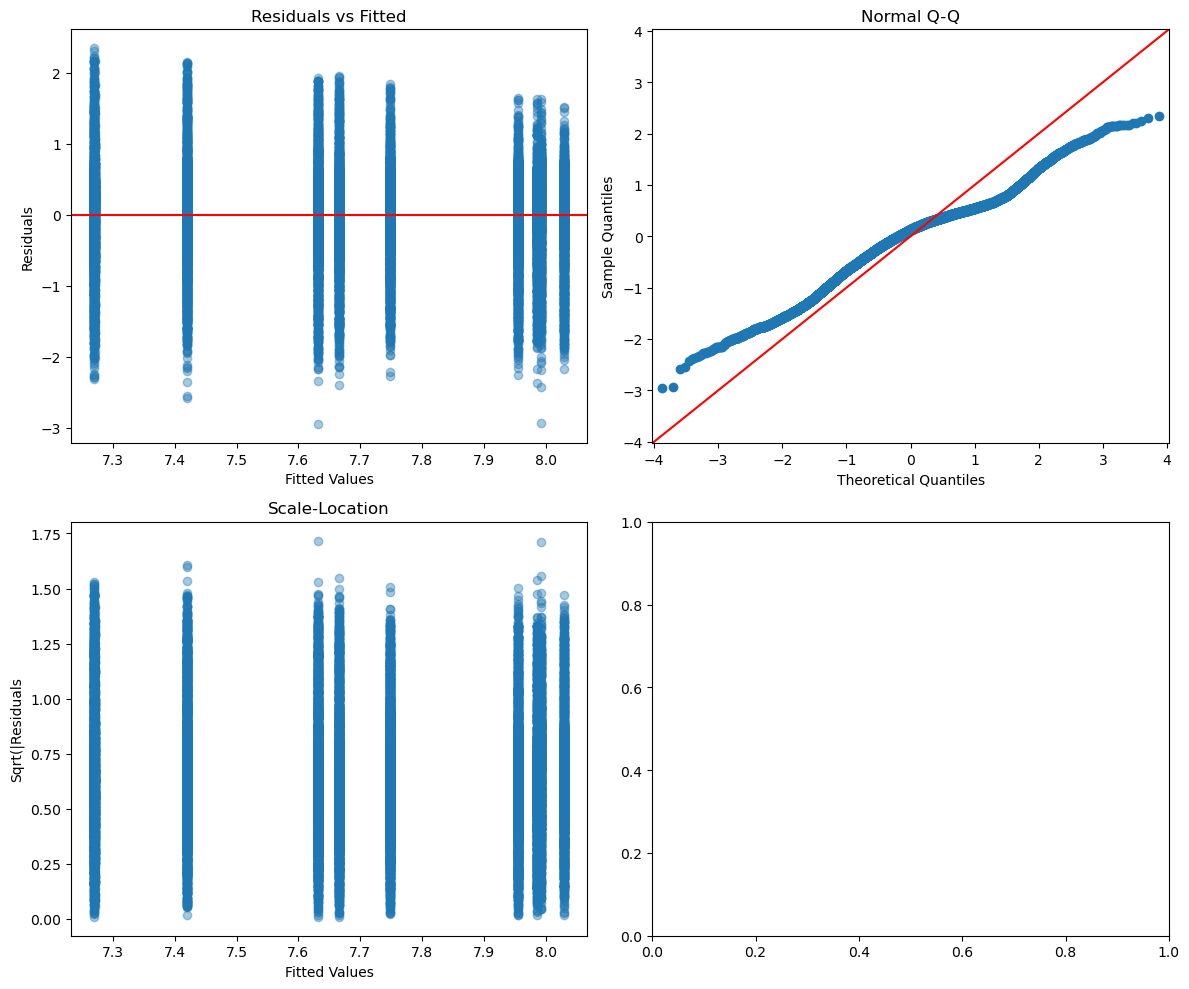

In [9]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(minnfitwts.fittedvalues, minnfitwts.resid, alpha=0.4)
axes[0,0].axhline(0, color="red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(minnfitwts.resid, line="45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(minnfitwts.fittedvalues, np.sqrt(np.abs(minnfitwts.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
plt.tight_layout()
plt.show()

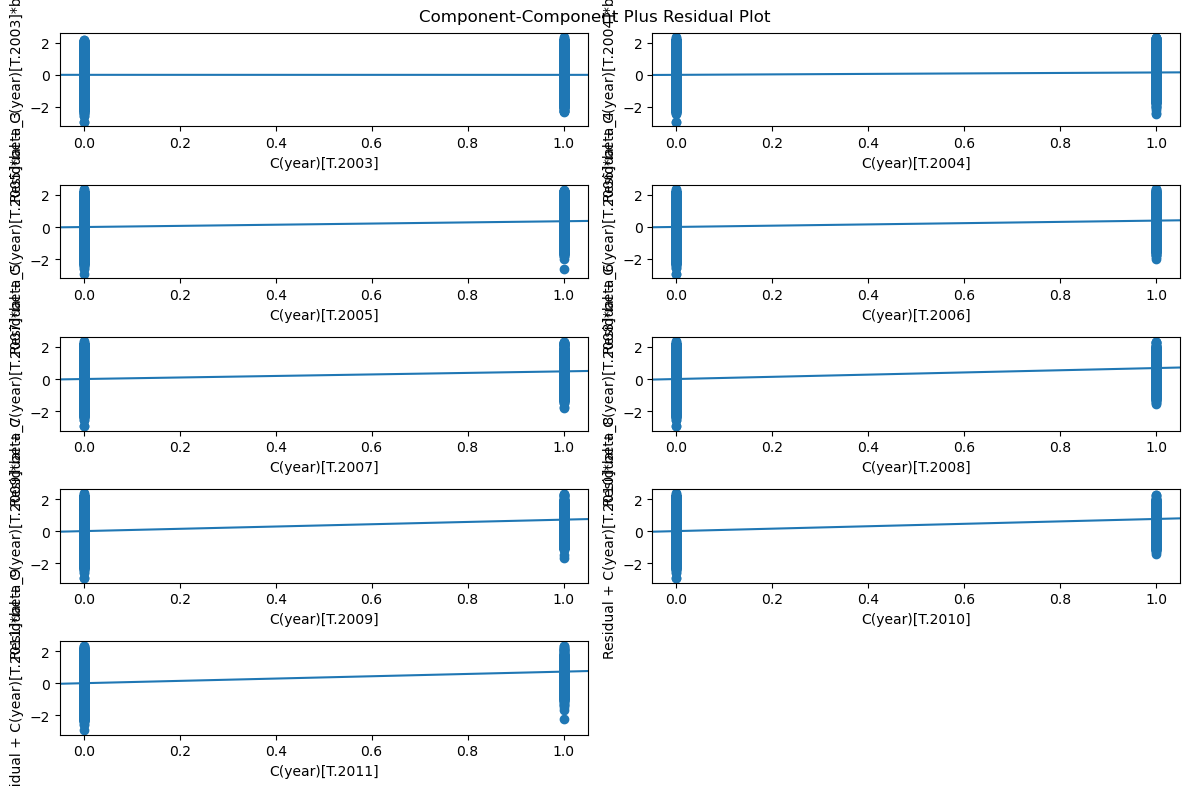

<Wald test (chi2): statistic=1610092.2801011105, p-value=0.0, df_denom=2>


In [10]:
fig = sm.graphics.plot_ccpr_grid(minnfitwts, fig=plt.figure(figsize=(12,8)))
plt.show()

print(sm.stats.diagnostic.linear_reset(minnfitwts))

In [11]:
rstudent = OLSInfluence(minnfitwts).resid_studentized_external

df = minnfitwts.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent), df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)
outlier_table

C:\Users\tariq\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


,rstudent,unadjusted p-value,Bonferri p-value
17451,14.017836,0.0,0.0
6895,-12.267451,0.0,0.0
12841,-13.645082,0.0,0.0
12840,-18.424134,0.0,0.0
6903,-10.851217,0.0,0.0
12839,-22.130796,0.0,0.0
12838,-14.089927,0.0,0.0
12836,-21.162169,0.0,0.0
12835,-16.666059,0.0,0.0
12834,-17.349629,0.0,0.0


Looking at the diagnostics, it doesn't seem as if we have a good fit as our model fails the bruesch-pragan test. So, homoscedasticity is non existant, even with weights. 

Now, we will introduce a new variable to the model. One that we have not used yet, "region". This too will be treated like a factor with its own baseline. 

In [12]:
minnfact = smf.ols("acrePrice_log~C(year)+C(region)", data=MinnLand).fit()
print(minnfact.summary())

                            OLS Regression Results                            
Dep. Variable:          acrePrice_log   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1669.
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:28:34   Log-Likelihood:                -12961.
No. Observations:               18700   AIC:                         2.595e+04
Df Residuals:                   18685   BIC:                         2.607e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

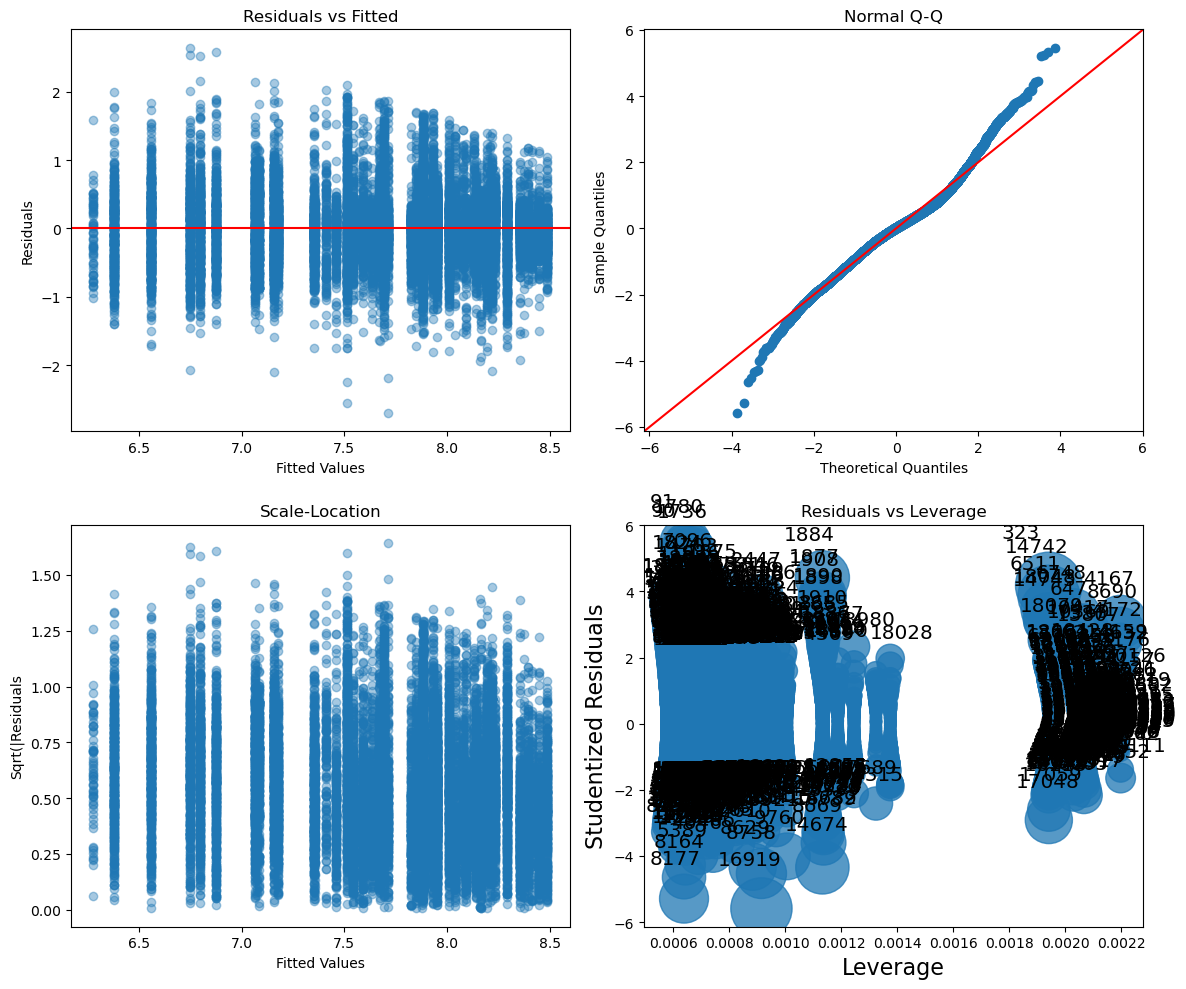

In [13]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(minnfact.fittedvalues, minnfact.resid, alpha=0.4)
axes[0,0].axhline(0, color="red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(minnfact.get_influence().resid_studentized_internal, line="45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(minnfact.fittedvalues, np.sqrt(np.abs(minnfact.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(minnfact, ax=axes[1,1], criterion="cooks")
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

In [14]:
minncvtest3 = ncvTest(minnfact.resid, minnfact.model.exog)

labels = ["BP statistics", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, minncvtest3):
    print(f"{stat}:{score}")

BP statistics:1135.1666352201883
BP p-value:1.4898740973653777e-233
f-value:86.25427921231558
f p-value:3.773452410177204e-241


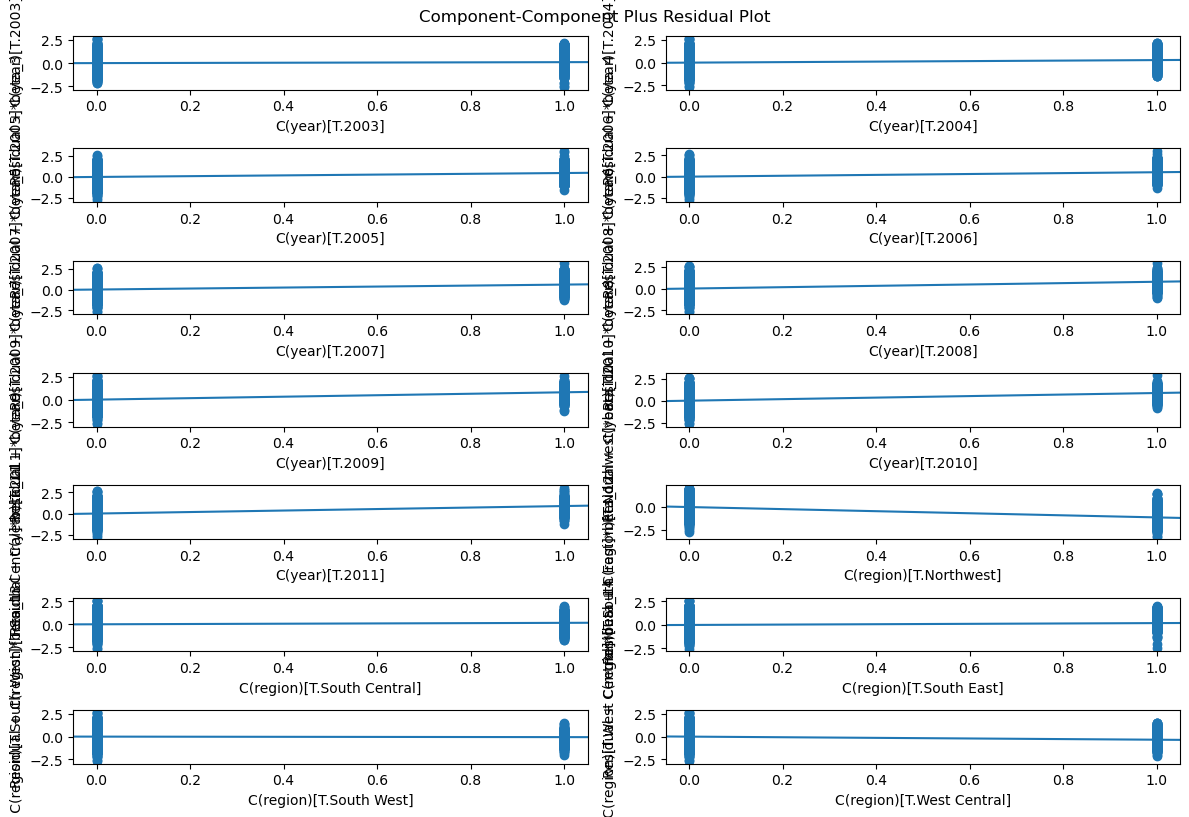

<Wald test (chi2): statistic=28.038155122409023, p-value=8.158155402067277e-07, df_denom=2>


In [15]:
fig = sm.graphics.plot_ccpr_grid(minnfact, fig=plt.figure(figsize=(12,9)))
plt.show()

print(sm.stats.diagnostic.linear_reset(minnfact))

In [16]:
rstudent = OLSInfluence(minnfact).resid_studentized_external

df = minnfact.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent), df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)
outlier_table

,rstudent,unadjusted p-value,Bonferri p-value
16919,-5.586576,2.348182e-08,0.000439
91,5.467608,4.619942e-08,0.000864
1780,5.338089,9.502751e-08,0.001777
8177,-5.289618,1.239530e-07,0.002318
90,5.249210,1.544231e-07,0.002888
1736,5.203598,1.975328e-07,0.003694
8164,-4.643597,3.447260e-06,0.064464
8758,-4.528747,5.970119e-06,0.111641
7096,4.462365,8.153370e-06,0.152468
1824,4.438015,9.131159e-06,0.170753


Looking at the data summary above as well as the diagnostics, we fail many assumptions in order to consider this a good model. Never the less, we can go ahead and try to interpret the summary table that we produced. The intercept represents the baseline category, which in our case is two categories. The year 2002 and the Central region. We see an increase in acre price each year in the central region. We also see rises in prices when we leave the central region for the south central and south east regions, however, we see drops in prices once we enter the north west, south west, and west central regions. What we are missing are interaction effects between year and region. We will model that next. 

In [17]:
minnint = smf.ols("acrePrice_log~C(year)+C(region)+C(year)*C(region)", data=MinnLand).fit()
print(minnint.summary())

                            OLS Regression Results                            
Dep. Variable:          acrePrice_log   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     403.6
Date:                Sun, 30 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:36:34   Log-Likelihood:                -12848.
No. Observations:               18700   AIC:                         2.582e+04
Df Residuals:                   18640   BIC:                         2.629e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

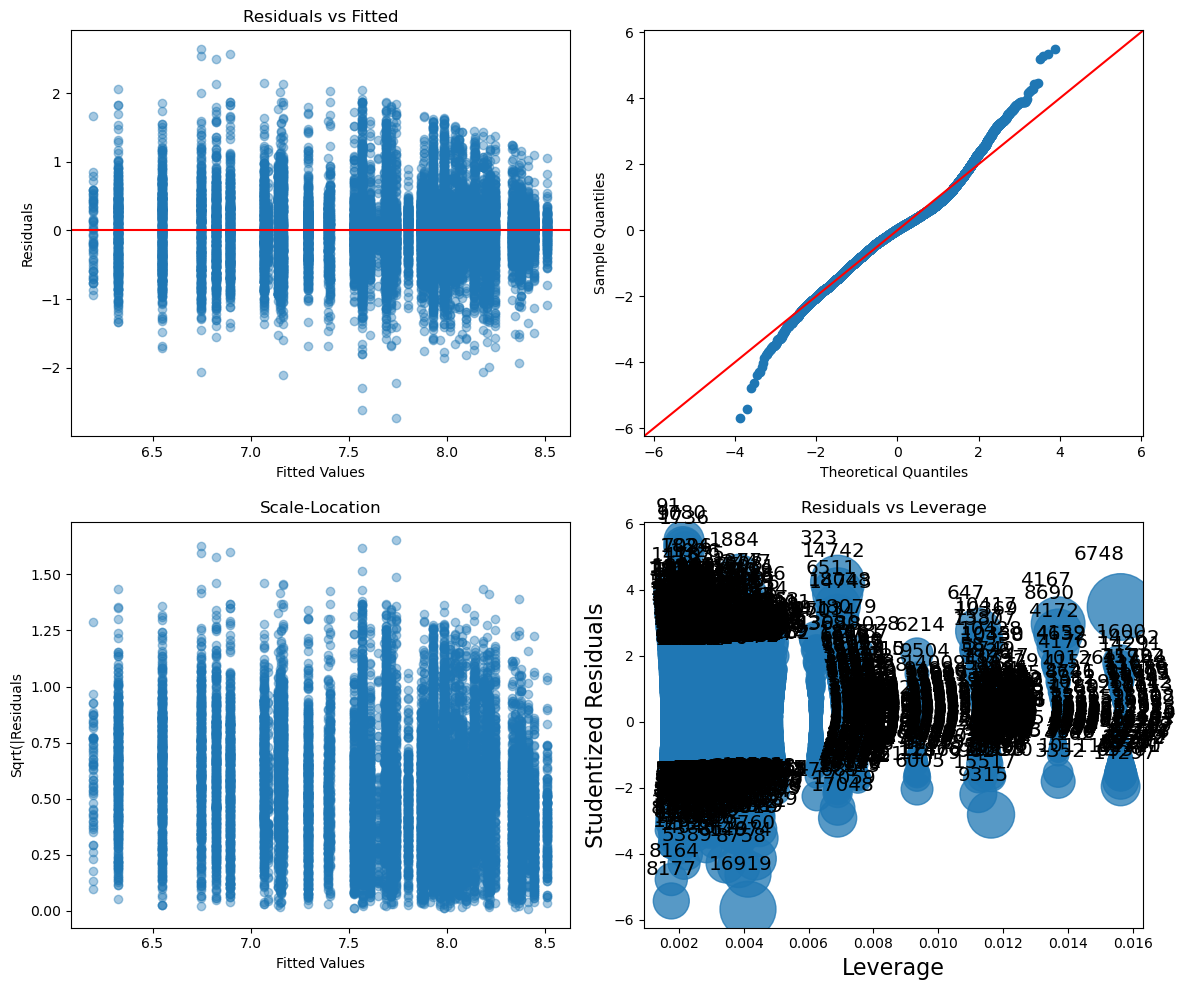

In [18]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(minnint.fittedvalues, minnint.resid, alpha=0.4)
axes[0,0].axhline(0, color="red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(minnint.get_influence().resid_studentized_internal, line="45", ax=axes[0,1])
axes[0,1].set_label("Normal Q-Q")
axes[1,0].scatter(minnint.fittedvalues, np.sqrt(np.abs(minnint.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(minnint, ax=axes[1,1], criterion="cooks")
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

In [19]:
minncvtest4 = ncvTest(minnint.resid, minnint.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, minncvtest4):
    print(f"{stat}:{score}")

BP statistic:1403.0495298142716
BP p-value:1.7717732708335342e-254
f-value:25.626975702065995
f p-value:1.6127580644191825e-265


C:\Users\tariq\anaconda3\Lib\site-packages\statsmodels\graphics\regressionplots.py:744: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()
C:\Users\tariq\AppData\Local\Temp\ipykernel_33796\2838545266.py:2: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


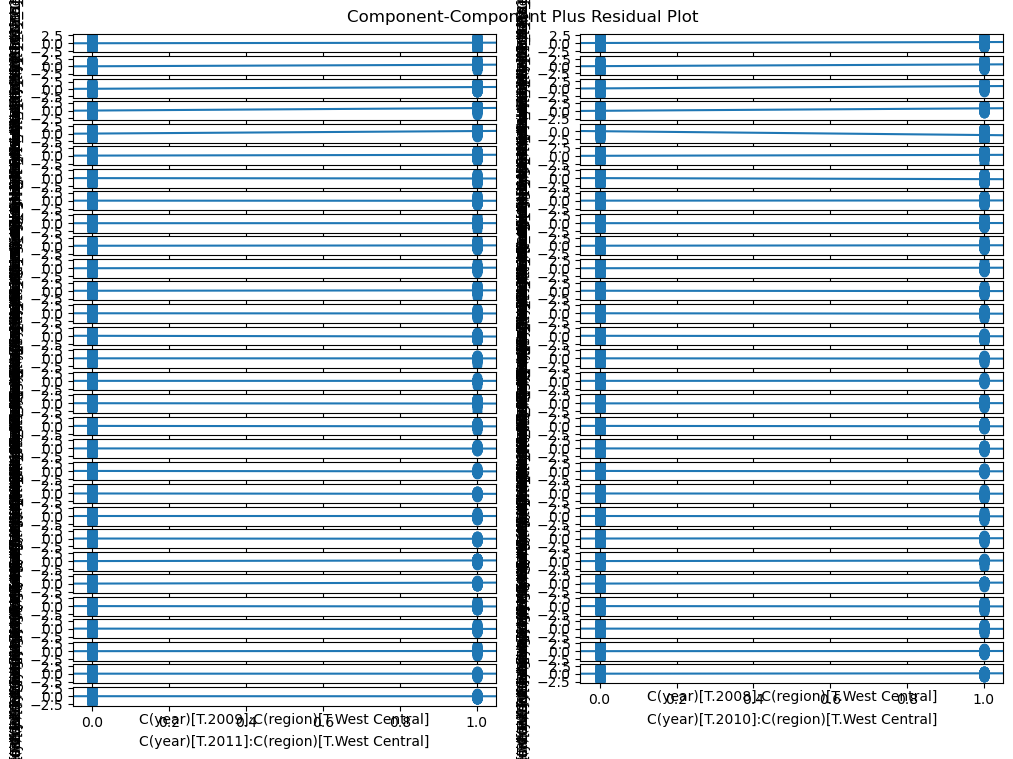

<Wald test (chi2): statistic=80518.77234551012, p-value=0.0, df_denom=2>


In [20]:
fig = sm.graphics.plot_ccpr_grid(minnint, fig=plt.figure(figsize=(12,8)))
plt.tight_layout()
plt.show()

print(sm.stats.diagnostic.linear_reset(minnint))

Running this new model allows us to see specific effects of region and year by creating an interaction of these two features. For instance, if I want to see insight of acre prices in the north west region in the year 2004, I can simply take the intercept, which is 7.404 add the coeffiecient for 2004 which is .2873, subtract the coeffieicent for the north west region, which is 1.2048, before finally add the coeffiecient for the interaction of 2004 and north west which should be .0611 which should bring us to 6.55 dollars per acre for that region during that time. However,this model is not a good one as it still violates several assumptions. We also see that many of the p-values for for our interaction scenarios are not significant. We can compare both models, the pure factor model, and the model with the interaction to see which is a better fit. We will use an anova to do so. 

In [21]:
anova_lm(minnfact, minnint)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,18685.0,4378.961965,0.0,NaN,NaN,NaN
1,18640.0,4326.348618,45.0,52.613348,5.037416,7.146899e-26


Our anova test confirms to us that the model with the interaction term is better than the model with just year and region. Although looking at the decrease in the residual sum of squares barely decreased. Regardless, we will go with the more complex model! We can also look at effect plots of each variable as well!

In [22]:
grid = (MinnLand[['year', 'region']].drop_duplicates().sort_values(['region', 'year']))

grid['pred'] = minnint.predict(grid)

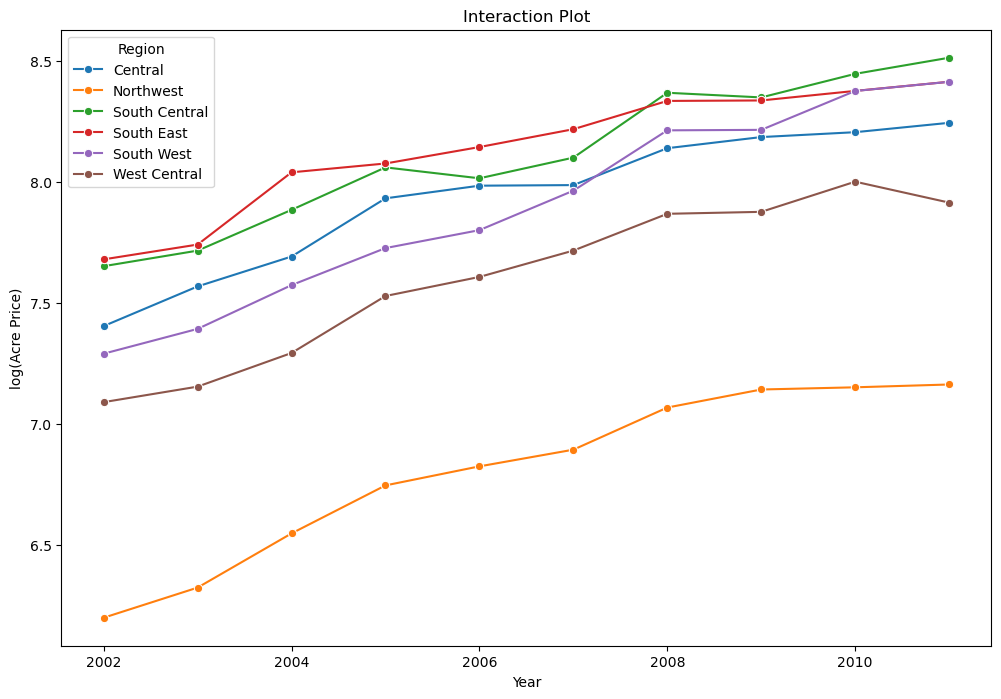

In [23]:
plt.figure(figsize=(12,8))
sns.lineplot(data=grid, x='year', y='pred', hue='region', marker='o')

plt.title("Interaction Plot")
plt.xlabel("Year")
plt.ylabel("log(Acre Price)")
plt.legend(title="Region")
plt.show()

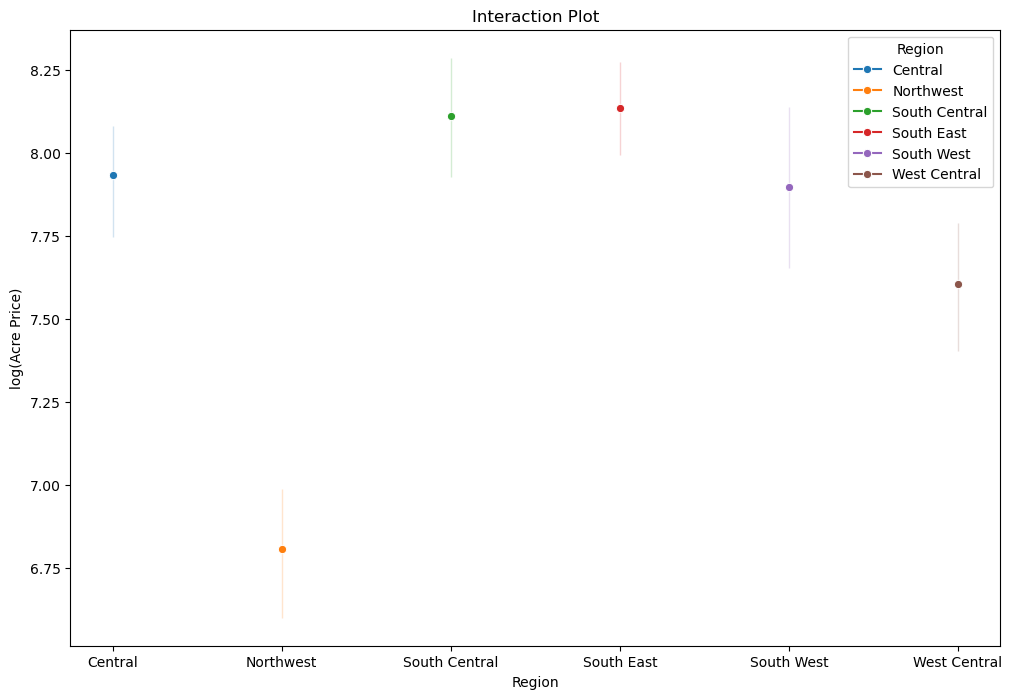

In [24]:
plt.figure(figsize=(12,8))
sns.lineplot(data=grid, x='region', y='pred', hue='region', marker='o')

plt.title("Interaction Plot")
plt.xlabel("Region")
plt.ylabel("log(Acre Price)")
plt.legend(title="Region")
plt.show()

Region shows movement from year to year amongst all regions. This is vital for descriptive purpose, but our main goal for now is to make sure our model meets assumptions before we can make any valid inferences. 

For our next problem I am going to investigate possible pay discrimination in a small midwestern college using variables such as rank, degree, years since degree, years in current rank, and finally salary as the predictor variable. First I will run a t-test to test the null that men receive just as much in salary, if not less than women. The alternative will be that men receive more. 

In [25]:
salary = pd.read_csv("http://users.stat.umn.edu/~sandy/alr4ed/data/salary.csv")

print(salary.head())


   Unnamed: 0   degree  rank     sex  year  ysdeg  salary
0           1  Masters  Prof    Male    25     35   36350
1           2  Masters  Prof    Male    13     22   35350
2           3  Masters  Prof    Male    10     23   28200
3           4  Masters  Prof  Female     7     27   26775
4           5      PhD  Prof    Male    19     30   33696


In [26]:
print(salary.describe(include="all"))

        Unnamed: 0   degree  rank   sex       year      ysdeg        salary
count    52.000000       52    52    52  52.000000  52.000000     52.000000
unique         NaN        2     3     2        NaN        NaN           NaN
top            NaN  Masters  Prof  Male        NaN        NaN           NaN
freq           NaN       34    20    38        NaN        NaN           NaN
mean     26.500000      NaN   NaN   NaN   7.480769  16.115385  23797.653846
std      15.154757      NaN   NaN   NaN   5.507536  10.222340   5917.289154
min       1.000000      NaN   NaN   NaN   0.000000   1.000000  15000.000000
25%      13.750000      NaN   NaN   NaN   3.000000   6.750000  18246.750000
50%      26.500000      NaN   NaN   NaN   7.000000  15.500000  23719.000000
75%      39.250000      NaN   NaN   NaN  11.000000  23.250000  27258.500000
max      52.000000      NaN   NaN   NaN  25.000000  35.000000  38045.000000


In [27]:
means = salary.groupby("sex")["salary"].mean()

original_differences = means.iloc[1] - means.iloc[0]

print(means)
print("differences:",original_differences)

sex
Female    21357.142857
Male      24696.789474
Name: salary, dtype: float64
differences: 3339.6466165413512


In [28]:
stats = scipy.stats.ttest_ind(salary["salary"][salary["sex"] == "Male"], salary["salary"][salary["sex"] == "Female"], equal_var=False, alternative="greater")

print(f"stats:{stats.statistic}",
      f"pvalue:{stats.pvalue}",
      f"df:{stats.df}")

stats:1.7744380049367063 pvalue:0.04504702854734463 df:21.591032008008757


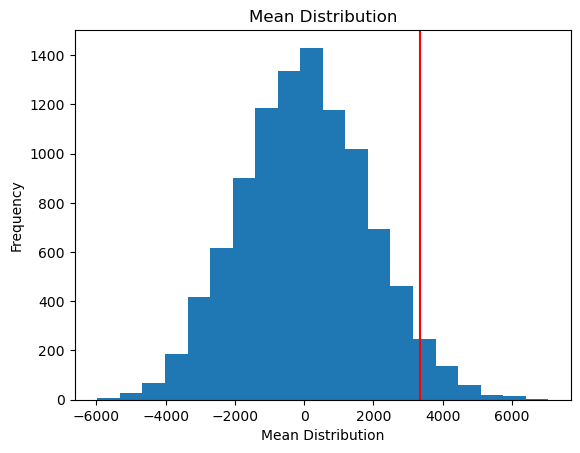

In [29]:
boots = []

for i in range(0,10000):
    new_salary = np.random.choice(salary["salary"], salary.shape[0], replace=False)
    salary_df = pd.DataFrame({"salary": new_salary, "sex": salary["sex"]})
    means = salary_df.groupby("sex")["salary"].mean()
    differences = means.iloc[0] - means.iloc[1]
    boots.append(differences)


plt.figure() 
plt.hist(boots, bins = 20)
plt.axvline(original_differences, color="red")
plt.xlabel("Mean Distribution")
plt.ylabel("Frequency")
plt.title("Mean Distribution")
plt.show()

In [30]:
pvalue = original_differences < boots

sum(pvalue)/10000

np.float64(0.0382)

In this scenario, we utilized both the Welch's t-test as well as a bootstrap sample t-test and both of them show similar scores. Our null hypothesis was that females make just as much as males do, if not more. The alternative was that males make more. With our .045 and .038, we can safely reject the null hypothesis at a significant level of 0.05. It seems as if we have enough data to suggest that it is in fact true. However, we need to further do some analysis to figure out the important drivers of salary. Several of the variables that we will be looking at are sex, degree, rank which are all factor or categorical variables, so they will be handled differently. Our continuous variables will be year and yrsdeg (years since degree). As you can guess, we may not be able to do to many power transformations to correct any linearity since we are dealing with a lot of categorical data. 

In [31]:
salfit = smf.ols("salary~C(sex)+C(degree)+C(rank)+year+ysdeg", data=salary).fit()
print(salfit.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     44.24
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           2.87e-17
Time:                        17:51:23   Log-Likelihood:                -474.72
No. Observations:                  52   AIC:                             963.4
Df Residuals:                      45   BIC:                             977.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          2.22e+04   1451.252  

Looking at the results, we can see the intercept as the baseline. It looks as if it represents being a female with a rank of an associate with a Master's degree. We also see some of the p-values coming back interesting. The male subgroup has a high p-value indicating that there is no difference in the male subgroup and the female subgroup. But that contradicts the information that we received from the two t-tests from earlier where we failed to reject the null hypothesis that there wasn't a difference in groups. Here, because the model is taking other data into account, the pvalue is a bit different. We also see that having a PhD doesn't seem to matter with it's high p-value. Assistant, Professor sub groups of Rank as well as years since degree (ysdeg) seem to show significance. The model reads, when you go from female to male, you will make 1,166.37 dollars less, which further contradicts our two earlier tests. If you go from Masters to PhD you are expected to receive 1,388.61 more. If you go from Associate to Assistant professor, you will see a decline of 5,592.36 dollars and if you go from associate to Professor, you will see an increase of 5,826.30 dollars. Each unit increase of year sees an increase of 476.31 dollars where else each year since degrees sees a decrease of 124.57 dollars. 

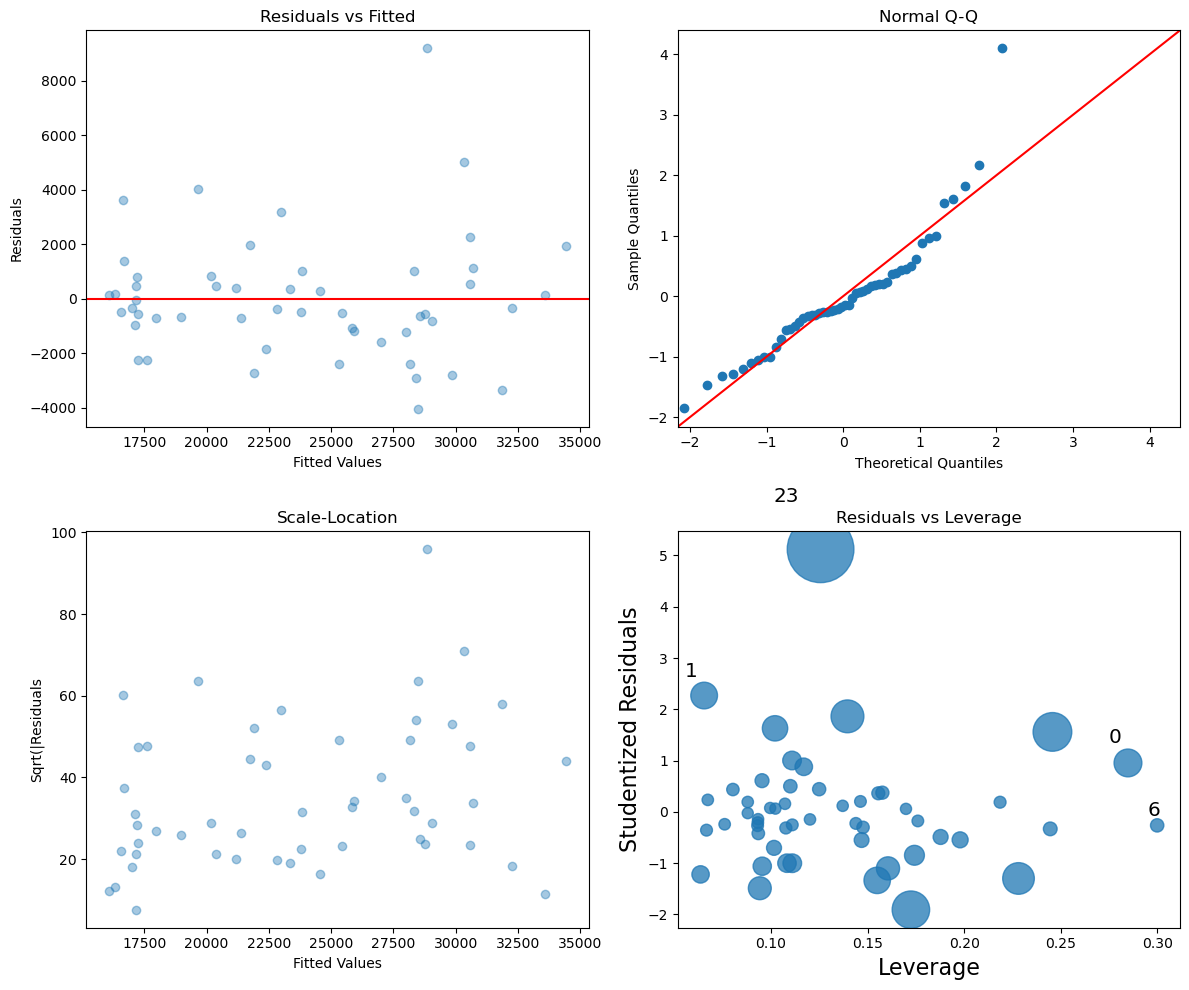

In [32]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(salfit.fittedvalues, salfit.resid, alpha=0.4)
axes[0,0].axhline(0, color="red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(salfit.get_influence().resid_studentized_internal, line="45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(salfit.fittedvalues, np.sqrt(np.abs(salfit.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(salfit, ax=axes[1,1], criterion="cooks")
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

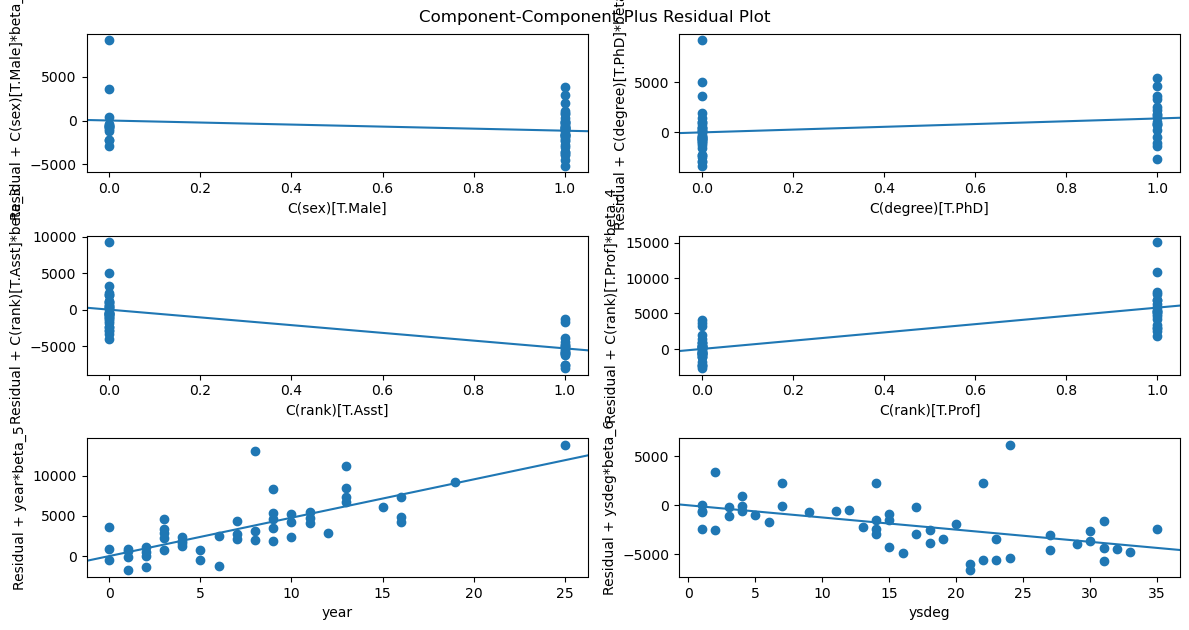

<F test: F=0.2689292166735772, p=0.8962690511454486, df_denom=41, df_num=4>


In [37]:
fig = sm.graphics.plot_ccpr_grid(salfit, fig=plt.figure(figsize=(12,8)))
plt.show()

print(sm.stats.diagnostic.linear_reset(salfit, power=[2,3], test_type="exog", use_f=True))

In [38]:
salncv = ncvTest(salfit.resid, salfit.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, salncv):
    print(f"{stat}:{score}")

BP statistic:5.902825374619651
BP p-value:0.4341633273491432
f-value:0.9603883680383393
f p-value:0.4626537975509246


In [39]:
X = salfit.model.exog
vif = pd.DataFrame({"Variable": salfit.model.exog_names,
                    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]})

print(vif)

           Variable        VIF
0         Intercept  19.038778
1    C(sex)[T.Male]   1.523618
2  C(degree)[T.PhD]   2.123396
3   C(rank)[T.Asst]   2.684178
4   C(rank)[T.Prof]   2.195272
5              year   2.422657
6             ysdeg   5.562508


Something new that we are introducing in our diagnostics is the variable inflation factor to detect any multicollinearity. The only one that we see that may cause issues is ysdeg(years since degree) which is already an insignificant variable.

In [40]:
rstudent = OLSInfluence(salfit).resid_studentized_external 

df = salfit.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent),df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)

outlier_table

,rstudent,unadjusted p-value,Bonferri p-value
23,5.120436,0.000006,0.00032
0,0.954263,0.345049,1.00000
28,1.559466,0.125892,1.00000
29,0.879291,0.383915,1.00000
30,0.188723,0.851158,1.00000
31,-0.224979,0.823014,1.00000
32,1.863044,0.068991,1.00000
33,-0.331342,0.741924,1.00000
34,-0.176552,0.860653,1.00000
35,0.203766,0.839455,1.00000


Finally, we are going to do the same model, but this time without rank. Although rank was considered significant within levels, we just want to do this in order to use the ANOVA to compare our two models. 

In [41]:
salfit2 = smf.ols("salary~C(degree)+C(sex)+year+ysdeg", data=salary).fit()
print(salfit2.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     20.11
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.05e-09
Time:                        18:09:56   Log-Likelihood:                -499.00
No. Observations:                  52   AIC:                             1008.
Df Residuals:                      47   BIC:                             1018.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.59e+04   1259.866  

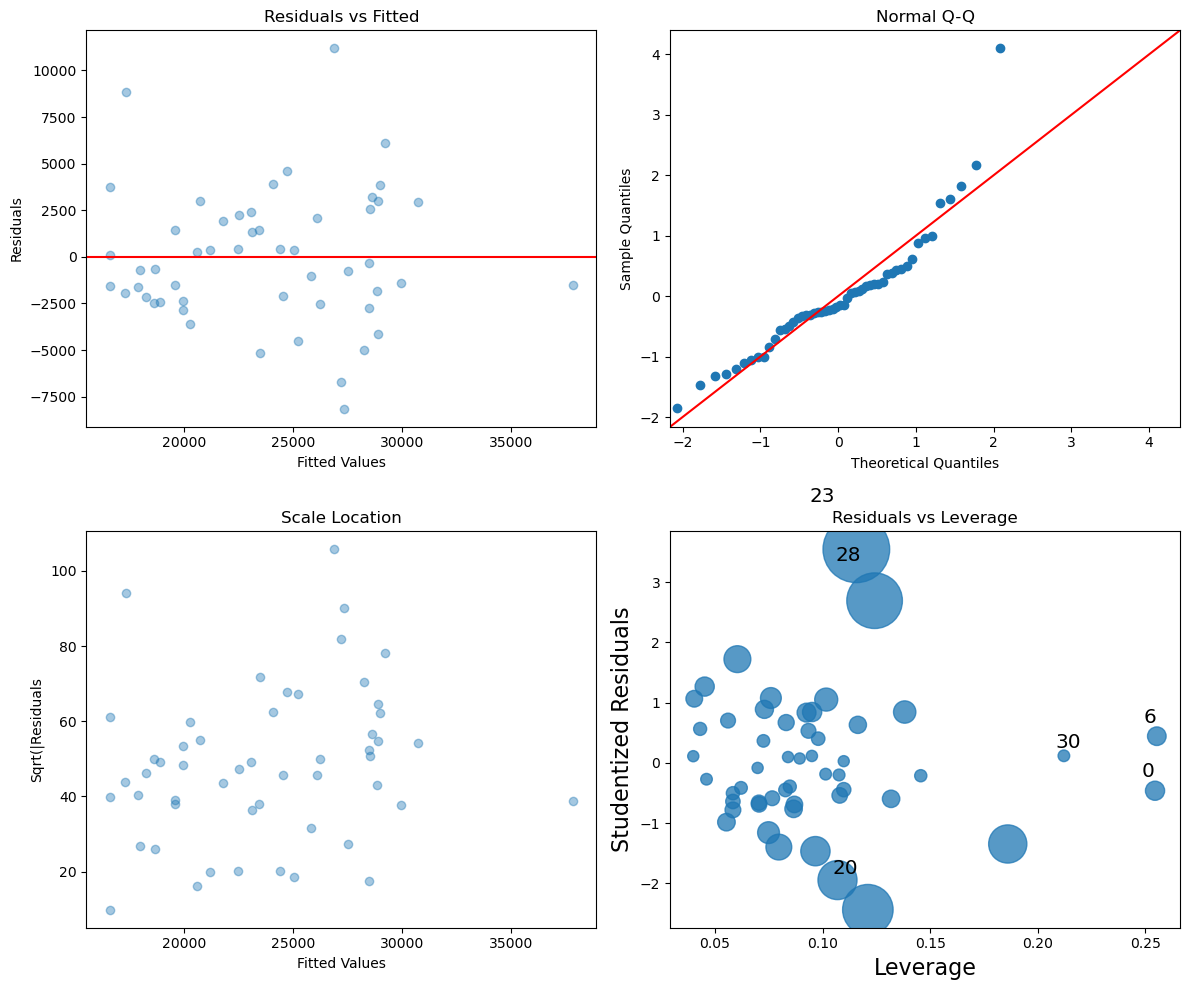

In [42]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(salfit2.fittedvalues, salfit2.resid, alpha=0.4)
axes[0,0].axhline(0, color = "red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(salfit.get_influence().resid_studentized_internal, line = "45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(salfit2.fittedvalues, np.sqrt(np.abs(salfit2.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale Location")
sm.graphics.influence_plot(salfit2, ax=axes[1,1], criterion="cooks")
axes[1,1].set_title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

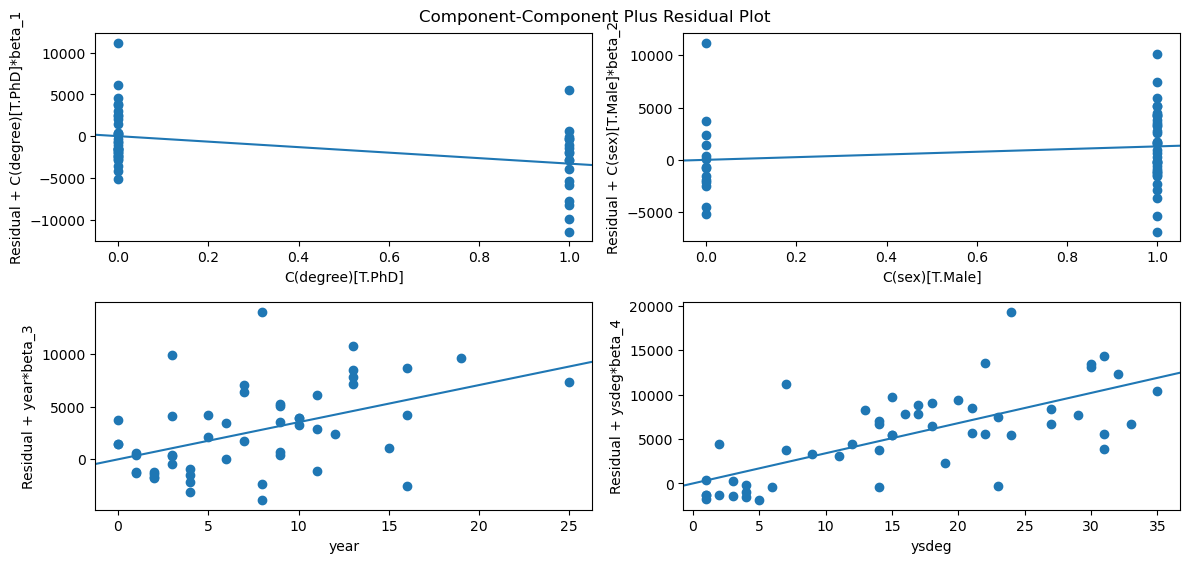

<F test: F=1.3182383627739214, p=0.2784757916839221, df_denom=43, df_num=4>


In [43]:
fig = sm.graphics.plot_ccpr_grid(salfit2, fig=plt.figure(figsize=(12,8)))
plt.show()

print(sm.stats.diagnostic.linear_reset(salfit2, power =[2,3], test_type = "exog", use_f = True))

In [45]:
salncvtest2 = ncvTest(salfit2.resid, salfit2.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "p f-value"]

for stat, score in zip(labels, salncvtest2):
    print(f"{stat}:{score}")

BP statistic:2.4306389167896416
BP p-value:0.657097519314267
f-value:0.5761625053898835
p f-value:0.68129553638131


In [46]:
X = salfit2.model.exog
vif = pd.DataFrame({"Variable": salfit2.model.exog_names,
                    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]})
print(vif)

           Variable       VIF
0         Intercept  5.889738
1  C(degree)[T.PhD]  1.424821
2    C(sex)[T.Male]  1.258752
3              year  2.241000
4             ysdeg  2.471785


In [47]:
rstudent = OLSInfluence(salfit2).resid_studentized_external

df = salfit2.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent), df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)
outlier_table

,rstudent,unadjusted p-value,Bonferri p-value
23,3.547861,0.000893,0.046437
28,2.693885,0.009761,0.507591
20,-2.440599,0.018486,0.961290
0,-0.463792,0.644937,1.000000
29,0.844098,0.402891,1.000000
30,0.116624,0.907655,1.000000
31,-1.399984,0.168085,1.000000
32,0.531610,0.597500,1.000000
33,-1.348654,0.183911,1.000000
34,-0.598519,0.552367,1.000000


In [49]:
anova_lm(salfit)

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,1.141062e+08,1.141062e+08,19.836252,5.527337e-05
C(degree),1.0,4.533026e+06,4.533026e+06,0.788022,3.794190e-01
C(rank),2.0,1.246075e+09,6.230375e+08,108.308983,6.306108e-18
year,1.0,1.472891e+08,1.472891e+08,25.604781,7.528308e-06
ysdeg,1.0,1.486816e+07,1.486816e+07,2.584684,1.148967e-01
Residual,45.0,2.588584e+08,5.752408e+06,NaN,NaN


In [50]:
anova_lm(salfit2, salfit)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,47.0,6.586490e+08,0.0,NaN,NaN,NaN
1,45.0,2.588584e+08,2.0,3.997907e+08,34.749854,7.484849e-10


The anova confirms that the model with rank is better as we have a p-value of less than 5%  when we compare models, telling us the chose the larger one. When looking at the larger one, we see that at a 5% alpha level, degree and ysdeg are two variables that we do not need. 

In [51]:
salfit3 = smf.ols("salary~C(sex)+C(rank)+year", data=salary).fit()

print(salfit3.summary())

print(sm.stats.diagnostic.linear_reset(salfit3))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     64.64
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.64e-18
Time:                        18:23:31   Log-Likelihood:                -476.26
No. Observations:                  52   AIC:                             962.5
Df Residuals:                      47   BIC:                             972.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         2.08e+04    987.193     

In [52]:
anova_lm(salfit, salfit3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,45.0,2.588584e+08,0.0,NaN,NaN,NaN
1,47.0,2.746881e+08,-2.0,-1.582972e+07,1.354258,NaN


As the anova tells us, we fail to reject the null and according to ocham's rule, we want to go with the less complex model.

Our next problem we are going to look at the strength of wool in a manufacturing setting based on the length of the yarn, the amount the yarn was asked to hold and the time the yarn was asked to hold per cycle. We will be looking a the wool data set from the alr4 package. 

In [53]:
wool = pd.read_csv(r"C:\Users\tariq\Desktop\Python and R Buda 1\Wool.csv")
print(wool.head())

   len  amp  load  cycles
0  250    8    40     674
1  250    8    45     370
2  250    8    50     292
3  250    9    40     338
4  250    9    45     266


In [54]:
print(wool.describe(include="all"))

              len       amp       load       cycles
count   27.000000  27.00000  27.000000    27.000000
mean   300.000000   9.00000  45.000000   861.370370
std     41.602515   0.83205   4.160251   882.056563
min    250.000000   8.00000  40.000000    90.000000
25%    250.000000   8.00000  40.000000   312.000000
50%    300.000000   9.00000  45.000000   566.000000
75%    350.000000  10.00000  50.000000  1105.000000
max    350.000000  10.00000  50.000000  3636.000000


In [55]:
wool["load"].unique()

array([40, 45, 50])

Looking at this data, we are dealing with mostly continous data. For our purpose, we want to turn the load variable into a factor with three levels. We will use all the other variables as predictors with cycles as the response. 

In [56]:
woolfit = smf.ols("cycles~len+amp+C(load)", data=wool).fit()
print(woolfit.summary())

                            OLS Regression Results                            
Dep. Variable:                 cycles   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     14.85
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           5.07e-06
Time:                        18:32:20   Log-Likelihood:                -203.26
No. Observations:                  27   AIC:                             416.5
Df Residuals:                      22   BIC:                             423.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2018.6111   1281.696      1.575

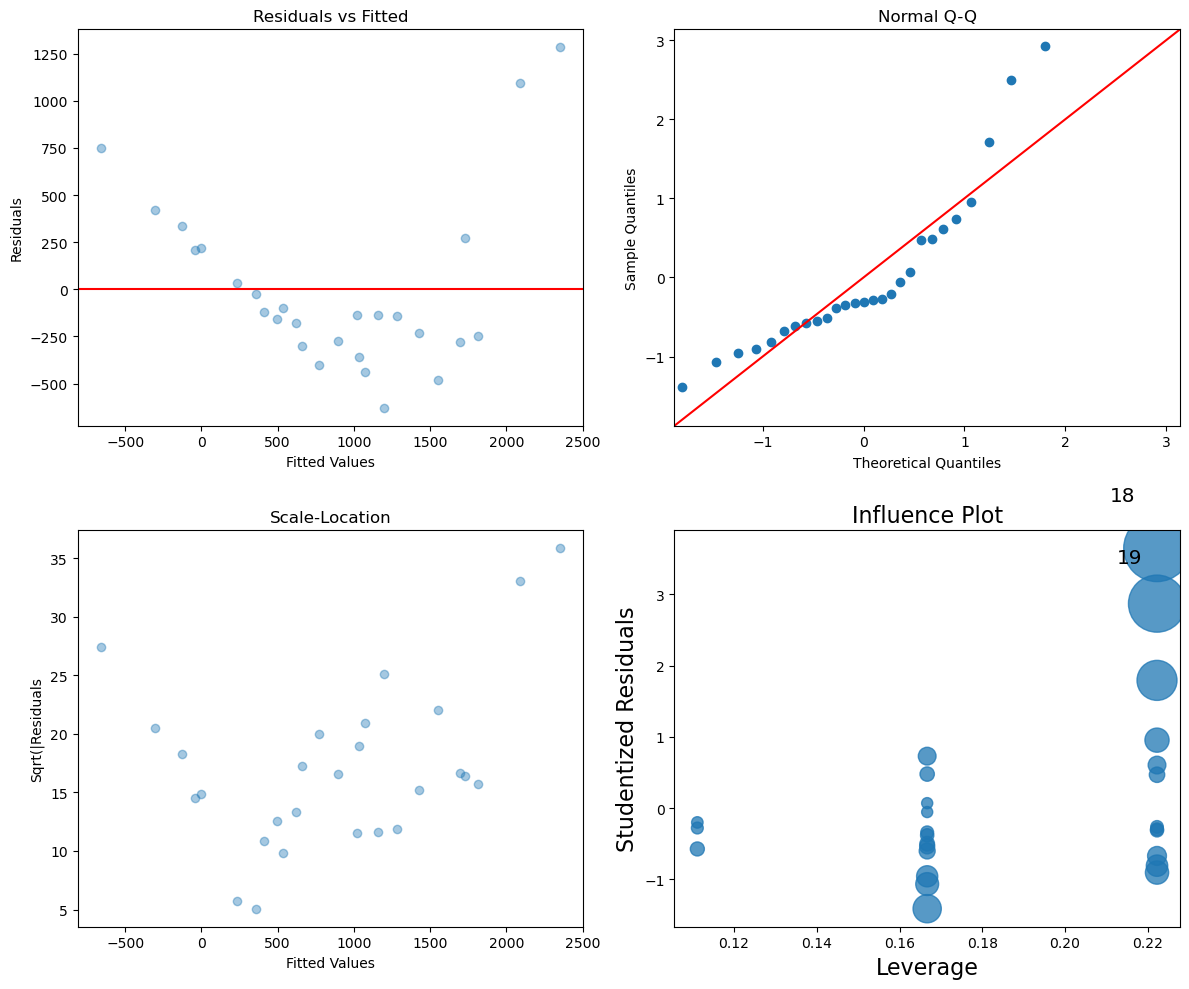

In [57]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

axes[0,0].scatter(woolfit.fittedvalues, woolfit.resid, alpha=0.4)
axes[0,0].axhline(0, color="red")
axes[0,0].set_xlabel("Fitted Values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residuals vs Fitted")
sm.qqplot(woolfit.get_influence().resid_studentized_internal, line="45", ax=axes[0,1])
axes[0,1].set_title("Normal Q-Q")
axes[1,0].scatter(woolfit.fittedvalues, np.sqrt(np.abs(woolfit.resid)), alpha=0.4)
axes[1,0].set_xlabel("Fitted Values")
axes[1,0].set_ylabel("Sqrt(|Residuals")
axes[1,0].set_title("Scale-Location")
sm.graphics.influence_plot(woolfit, ax=axes[1,1], criterion="cooks")
axes[1,1].set_label("Residuals vs Leverage")
plt.tight_layout()
plt.show()

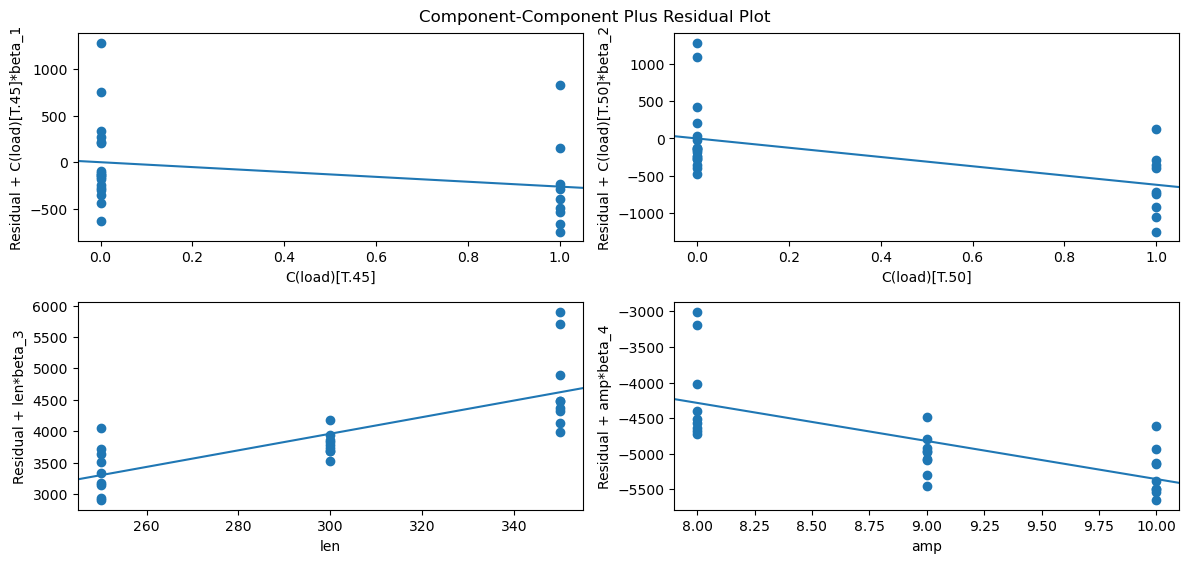

<F test: F=10.382814009689504, p=0.00010200525056761869, df_denom=20, df_num=4>


In [60]:
fig = sm.graphics.plot_ccpr_grid(woolfit, fig=plt.figure(figsize=(12,8)))
plt.show()

print(sm.stats.diagnostic.linear_reset(woolfit, power=[2,3], test_type="exog", use_f = True))

In [61]:
woolncv = ncvTest(woolfit.resid, woolfit.model.exog)

labels = ["BP statistic", "BP p-value", "f-value", "f p-value"]

for stat, score in zip(labels, woolncv):
    print(f"{stat}:{score}")

BP statistic:5.274907299041234
BP p-value:0.26023511724414705
f-value:1.33541387114295
f p-value:0.28824002248404285


In [62]:
X = woolfit.model.exog
vif = pd.DataFrame({"Variable": woolfit.model.exog_names,
                    "VIF": [variance_inflation_factor(X,i) for i in range(X.shape[1])]})

print(vif)

        Variable         VIF
0      Intercept  178.500000
1  C(load)[T.45]    1.333333
2  C(load)[T.50]    1.333333
3            len    1.000000
4            amp    1.000000


In [63]:
rstudent = OLSInfluence(woolfit).resid_studentized_external

mask = np.isfinite(rstudent)
rstudent = rstudent[mask]
df = woolfit.df_resid
pval = 2 * (1 - t.cdf(np.abs(rstudent), df))
bonf_pval = np.minimum(pval * len(pval), 1.0)

outlier_table = pd.DataFrame({"rstudent": rstudent, "unadjusted p-value": pval, "Bonferri p-value": bonf_pval})
outlier_table = outlier_table.sort_values("Bonferri p-value").head(10)

outlier_table

,rstudent,unadjusted p-value,Bonferri p-value
18,3.647167,0.001420,0.038349
19,2.870523,0.008886,0.239917
0,-0.807761,0.427876,1.000000
24,-0.312478,0.757620,1.000000
23,-1.411888,0.171971,1.000000
22,-1.065932,0.298013,1.000000
21,-0.536342,0.597104,1.000000
20,0.604627,0.551613,1.000000
17,0.477910,0.637429,1.000000
16,-0.055231,0.956453,1.000000


The summary statistics of our model gives us insight. Since load is our factor, the intercept corresponds to a load level of 40. When we go from a load of 40 to a load of 45, we see a decrease of about 256 cycles. When we go from 40 to 50 we see a loss of about 622 cycles. We see with a unit increase of length, our cycles increase by 13.2 and a unit increase in amp corresponds to a decrease of about 536 cycles. One thing that jumps out, however is that the difference between a load of 40 and 45 does not seem significant according to the p-value when we test it at a value of .05. We will use an anova test to truly see if there is a difference between the load groups. We will use the Tukey Honest Significance Difference test. 

In [64]:
tukey = pairwise_tukeyhsd(endog=wool["cycles"],
                          groups=wool["load"],
                          alpha=0.05)

print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
    40     45 -262.5556 0.8026 -1295.4476 770.3365  False
    40     50 -621.6667 0.3073 -1654.5588 411.2254  False
    45     50 -359.1111  0.665 -1392.0032  673.781  False
---------------------------------------------------------


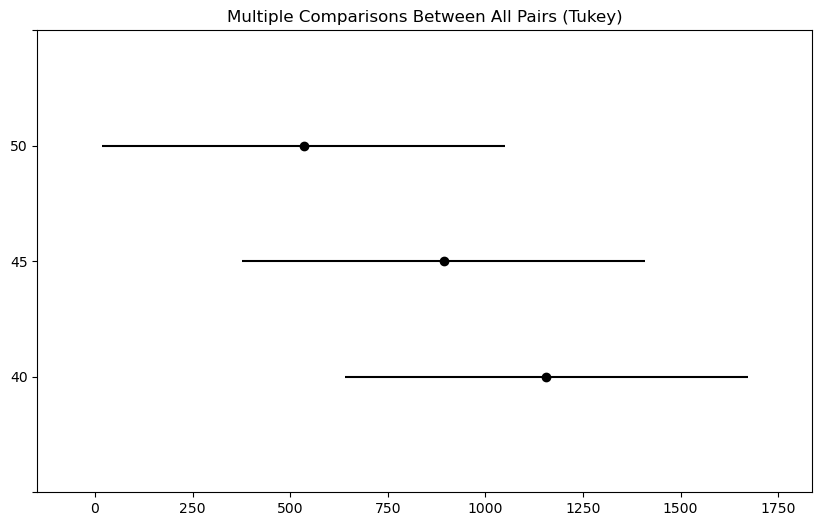

In [65]:
tukey.plot_simultaneous(figsize=(10,6))
plt.show()

Looking at the test, it tells us that the difference of the mean in cycles between 40 and 50 is 262.56, but can be anywhere from -1295.45 and 770.34. For 40 and 50 the mean difference is 621.67, but the range is anywhere from -1654.56 and 441.23. For 40 and 50 the difference is 359.11, but can be anywhere from -1392 and 673.78. The main thing that jumps out, however, is that the difference between all these levels are insignificant meaning there is no difference in the load levels. Our original summary told us that for 40 and 45, but not necessarily 40 and 50. 

Our anova tells us that load is still a significant variable even at the 5% level. It would be safe to keep it, but we do have to understand that the levels within do not matter, however. Because it barely passes the p-value threshold, I would normally just drop it. 

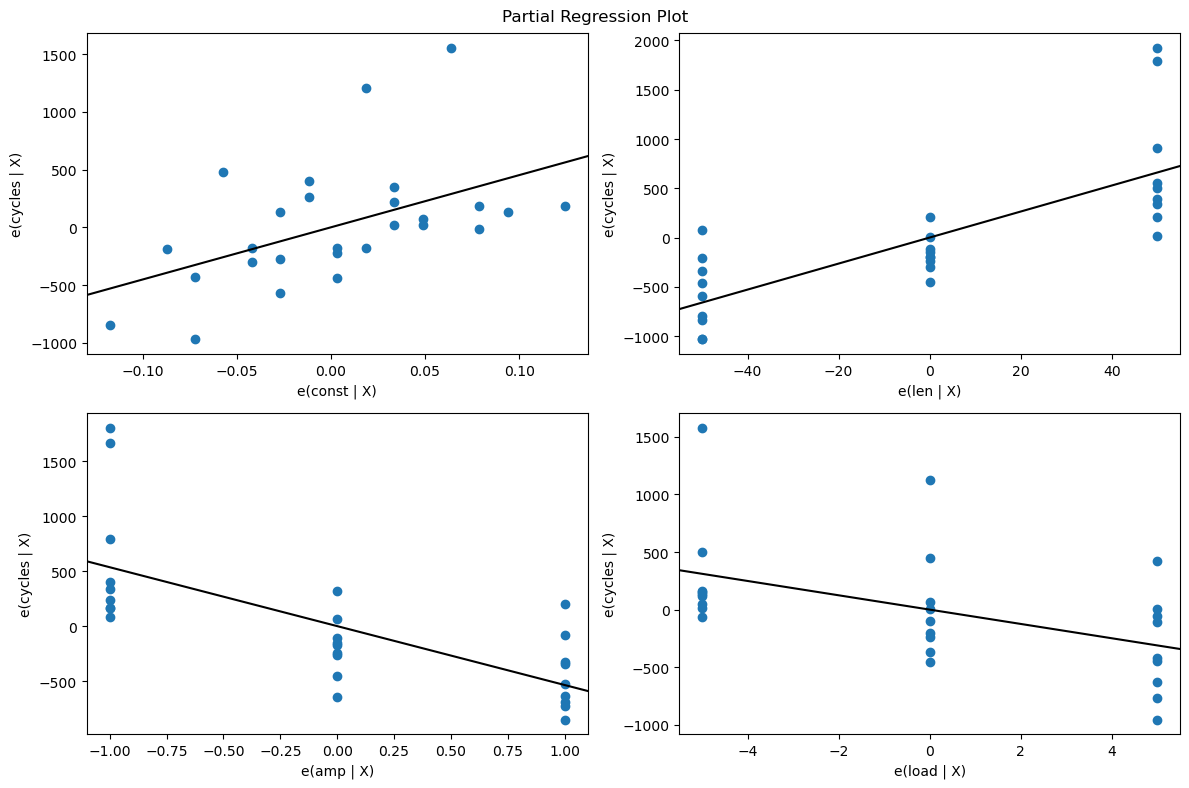

            df        sum_sq       mean_sq          F    PR(>F)
C(load)    2.0  1.753097e+06  8.765485e+05   3.527610  0.046901
len        1.0  7.840800e+06  7.840800e+06  31.554773  0.000012
amp        1.0  5.168113e+06  5.168113e+06  20.798722  0.000153
Residual  22.0  5.466609e+06  2.484822e+05        NaN       NaN


In [66]:
Y = wool["cycles"]
X = wool[["len","amp","load"]]
X = sm.add_constant(X)
woolfitcont = sm.OLS(Y,X).fit()

fig = sm.graphics.plot_partregress_grid(woolfitcont, fig=plt.figure(figsize=(12,8)))
plt.show()
print(anova_lm(woolfit, type=2))